In [1]:
import mgplvm as mgp
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
device = mgp.utils.get_device()
from synthetic_data import *

# set random seeds
np.random.seed(11121401)
torch.manual_seed(11121401)

def detach(tensor):
    return tensor.detach().cpu().numpy()

loading


In [2]:

# callback function for printing progress
def cb_ard(mod, i, loss):
    if i % 150 == 0:
        print('')
        ls, ss = detach(mod.obs.dim_scale).flatten()**(-1), np.mean(detach(mod.lat_dist.scale), axis = (0, -1))
        ms = np.sqrt(np.mean(detach(mod.lat_dist.nu)**2, axis = (0, -1)))
        args = np.argsort(ls)
        print(np.round(ls[args], 2), '', np.round(ss[args], 2), '', np.round(ms[args], 2))
    return False


#### generate latents and tuning curves ####
n, T, n_samples = 35, 2000, 1 # number of neurons, time points, trials
ts = np.arange(T) # timepoints
fit_ts = torch.tensor(ts)[None, None, :].to(device) # create torch tensor
dts_2 = (ts[:, None] - ts[None, :])**2 # squared time differences
ell = 20 # true length scale
d_true = 2 # true latent dim
K = np.exp(-dts_2/(2*ell**2)) # TxT kernel
L = np.linalg.cholesky(K + np.eye(T)*1e-6) # TxT sqrt kernel
xs = (L @ np.random.normal(0, 1, (T, d_true))).T # DxT latents
C = np.random.normal(0, 1, (n, d_true))*0.5 # factor matrix
F = C @ xs # n x T 'noise-free' activities

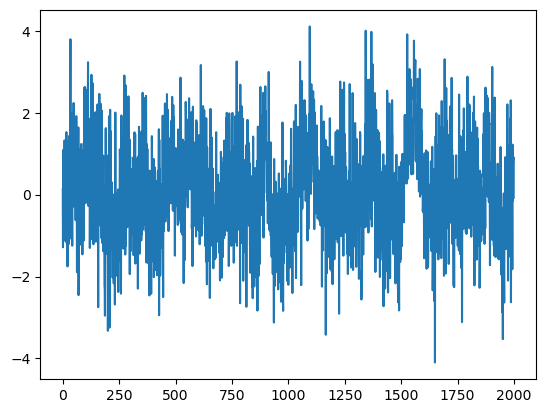

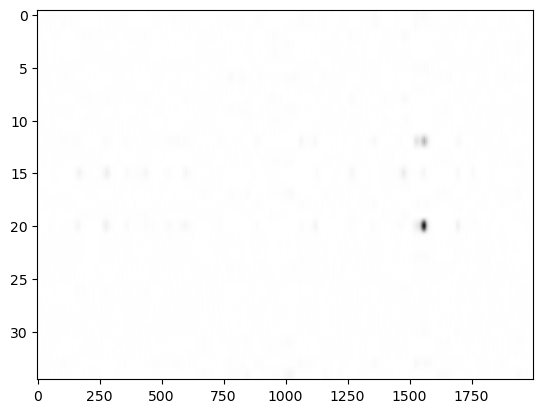

(35,) (35, 2000)


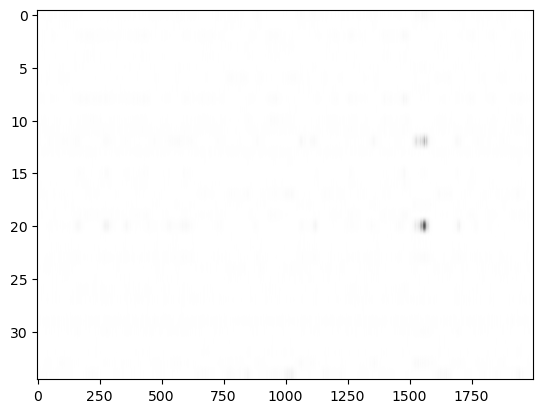

[1.3375 1.3205 1.205  1.0885 1.0185 1.2295 1.3835 1.102  1.283  1.2775
 1.1035 0.9765 3.507  0.97   1.162  2.8855 1.136  1.315  1.29   1.148
 5.303  1.154  1.0655 1.172  1.1905 1.0255 1.1125 1.057  1.0115 1.0555
 1.1775 1.184  1.0235 1.63   1.64  ]
(1, 35, 800)
[[0.02875 0.02625 0.03125 0.0325  0.025   0.01625 0.0225  0.0375  0.0375
  0.02875 0.01375 0.0425  0.025   0.0225  0.02125 0.035   0.01875 0.03
  0.02375 0.03    0.02875 0.02    0.03375 0.03125 0.0275  0.02125 0.0175
  0.02375 0.025   0.02875 0.0175  0.0325  0.025   0.0325  0.025  ]]


In [3]:
## generate Gaussian data
sig = 1.5*np.std(F) # noise scale for Gaussian data
YGauss = F + np.random.normal(0, sig, (F.shape)) #n x T observations with gaussian noise
plt.plot(YGauss[0])
plt.show()

## generate Poisson data
c_p = 0 # potential offset
YPois = np.random.poisson(np.exp(F + c_p)).astype(float) # sample data
# plot data
plt.figure()
plt.imshow(YPois, cmap = 'Greys', aspect = 'auto')
plt.show()
plt.close()

c_nb = -1.55 # potential offset
# NB distribution parameters
p_nb = np.exp(F+c_nb)/(1+np.exp(F+c_nb))
r_nb = np.random.uniform(1, 10, n) # n failues

#numpy defines in terms of #successes so we substitute 1 -> 1-p
print(r_nb.shape, p_nb.shape)
YNB = np.random.negative_binomial(r_nb, 1-p_nb.T).astype(float).T # NB data

# plot NB data
plt.figure()
plt.imshow(YNB, cmap = 'Greys', aspect = 'auto')
plt.show()
plt.close()

# print some data info
print(np.mean(YPois, axis = -1))
# print(np.amax(YPois, axis = -1))
# print(np.mean(YNB, axis = -1))
# print(np.amax(YNB, axis = -1))
# print(np.mean(np.mean(YNB, axis = -1) / np.mean(YPois, axis = -1)))

s = SyntheticData(dt=0.025, D=2, l=0.2, stop=20, c_var=0.5**2, N=35, d=0)
Y2 = s.get_Y(link='exp')
print(Y2.shape)
print(np.mean(Y2, axis = -1))



In [4]:

mods = [] # list of models

d_fit = 10 # dimensionality to fit
labs = ['Gauss', 'Pois', 'NB'] # model labels
for i, newY in enumerate([YGauss, YPois, YNB]): # for each dataset
    if i != 0:
        continue
    print('\n', i, labs[i]) # print some stuff
    Y = newY[None, ...] # add trial dimension
    data = torch.tensor(Y).to(device) # create torch tensor

    if i == 0: # Gaussian
        lik = mgp.likelihoods.Gaussian(n, Y=Y, d=d_fit)
    elif i == 1: # Poisson
        lik = mgp.likelihoods.Poisson(n)
    elif i == 2: # NB
        lik = mgp.likelihoods.NegativeBinomial(n, Y=Y)
    rel_scale = 0.1 if i == 1 else 1 # set relative scale

    # instantiate model
    manif = mgp.manifolds.Euclid(T, d_fit) # Euclidean latents
    lprior = mgp.lpriors.Null(manif) # need to do this
    # specify GP latent distribution -- initialize ell at 80% of true value
    lat_dist = mgp.rdist.GP_circ(manif, T, n_samples, fit_ts, _scale=1, ell = 20*0.8, prior_fourier_func=mgp.rdist.prior_kernels.k_1_2_rational_quadratic_1)
    # put together in model
    mod = mgp.models.Lvgplvm(n, T, d_fit, n_samples, lat_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = rel_scale).to(device)
    # instantiate some training parameters
    train_ps = mgp.crossval.training_params(max_steps = 2501, n_mc = 10, burnin = 50, lrate = 5e-2, callback = cb_ard)
    # train the model
    mod_train = mgp.crossval.train_model(mod, data, train_ps)
    # append to list of models
    mods.append(mod)

# put all of the data in a dict
data = {'YGauss': YGauss,
       'YPoiss': YPois,
        'YNB': YNB,
        'c_p': c_p,
        'c_nb': c_nb,
        'r_nb': r_nb,
        'p_nb': p_nb,
        'xs': xs,
        'C': C,
        'F': F,
        'ell': ell
       }




 0 Gauss


iter   0 | elbo -2.634 | kl  0.000 | loss  2.634 | |mu| 0.051 | sig 1.000 | prior_ell 16.000 |scale 0.167 | lik_sig 1.595 |

[ 1.75  2.19 10.21 10.97 11.75 11.92 12.45 13.38 14.43 15.58]  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
iter  50 | elbo -1.593 | kl  0.021 | loss  1.606 | |mu| 0.318 | sig 0.974 | prior_ell 15.841 |scale 0.153 | lik_sig 1.416 |
iter 100 | elbo -1.524 | kl  0.017 | loss  1.538 | |mu| 0.249 | sig 0.956 | prior_ell 15.858 |scale 0.151 | lik_sig 1.107 |
iter 150 | elbo -1.518 | kl  0.016 | loss  1.533 | |mu| 0.220 | sig 0.948 | prior_ell 16.354 |scale 0.152 | lik_sig 1.100 |

[ 2.18  2.75  7.96  9.29  9.43 11.02 12.92 14.38 17.02 17.18]  [0.93 0.93 0.92 0.93 0.93 0.94 0.96 0.96 0.98 0.98]  [0.03 0.02 0.32 0.28 0.32 0.27 0.25 0.17 0.13 0.14]
iter 200 | elbo -1.514 | kl  0.016 | loss  1.529 | |mu| 0.205 | sig 0.945 | prior_ell 17.162 |scale 0.153 | lik_sig 1.094 |
iter 250 | elbo -1.512 | kl  0.014 | loss  1.526 | |mu| 0.190 

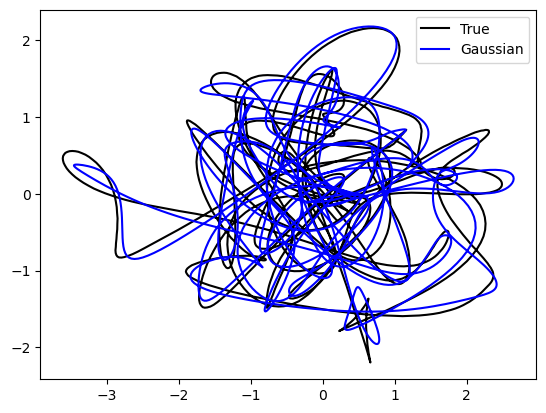

In [5]:

xs = data['xs'].T # true latents
xs = xs - np.mean(xs, axis = 0, keepdims = True) # mean subtract

labs = ['Gauss', 'Pois', 'NB'] # labels
cols = ['b', 'g', 'r'] # colours for plottings

#### plot latents ####
plt.figure()
plt.plot(xs[:, 0], xs[:, 1], 'k-') # plot true latents
for i, mod in enumerate(mods):
    lats = detach(mods[i].lat_dist.lat_mu)[0, ...] # extract model latents
    dim_scales = detach(mods[i].obs.dim_scale).flatten() # latent scales
    inds = np.argsort(-dim_scales)[:2] # pick the two most informative dimensions
    lats = lats[..., inds] # extract corresponding latents
    lats = lats - np.mean(lats, axis = 0, keepdims = True) # mean subtract

    #fit xs = mus @ T --> T = (mus' * mus)^(-1) * mus' * xs
    T = np.linalg.inv(lats.T @ lats) @ lats.T @ xs # linear regression
    lats = lats @ T  #predicted values

    plt.plot(lats[:, 0], lats[:, 1], cols[i]+'-') # plot inferred latents

plt.legend(['True', 'Gaussian', 'Poisson', 'Negative Binomial'])
plt.show()
plt.close()



plotting informative and discarded dimensions


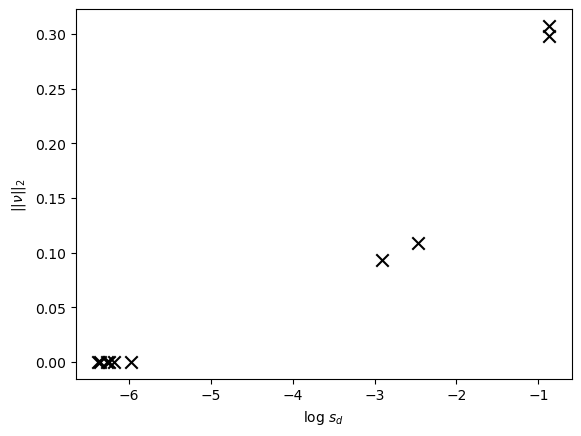

In [6]:
### we start by plotting 'informative' and 'discarded' dimensions ###
for mod in mods:
    nu = True
    print('plotting informative and discarded dimensions')
    dim_scales = mod.obs.dim_scale.detach().cpu().numpy().flatten(
    )  #prior scales (s_d)
    dim_scales = np.log(dim_scales)  #take the log of the prior scales
    plt.figure()
    if nu:
        nus = np.sqrt(
            np.mean(mod.lat_dist.nu.detach().cpu().numpy()**2,
                    axis=(0, -1)))  #magnitude of the variational means
        plt.scatter(
            dim_scales, nus, c='k', marker='x',
            s=80)  #top right corner are informative, lower left discarded
        plt.ylabel(r'$||\nu||_2$', labelpad=5)
    else:
        # nu is shape [n_trials, n_dims, n_times]
        # lat_mu is shape [n_trials, n_times, n_dims]
        lat_mu = mod.lat_dist.lat_mu.detach().cpu().numpy()
        mus = np.sqrt(np.mean(lat_mu**2, axis=(0, 1)))
        plt.scatter(dim_scales, mus, c='k', marker='x', s=80)
        plt.ylabel(r'$||\mu||_2$', labelpad=5)

    plt.xlabel(r'$\log \, s_d$')

    plt.show()

(1, 35, 2000) (1, 35, 2000) Ypred, Ytest
LL -1.7058209771502706 MSE 1.1784009553219374


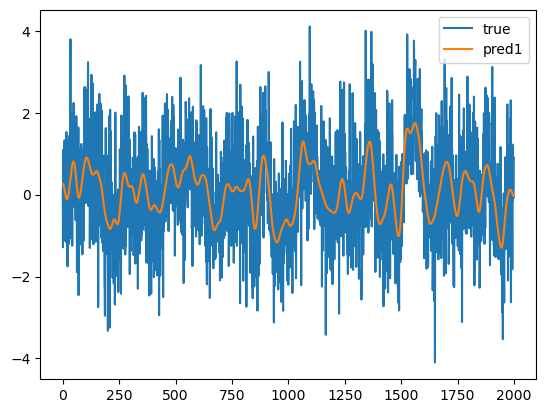

In [12]:
latents = mod.lat_dist.lat_mu.detach().cpu(
        )  # extract test latent means (shape ntrial, T2, d)
        # construct input for prediction of neural activity
query = latents.transpose(-1, -2).to(device)  #(ntrial, d, m)

        # predicted 'F' # aa2236 this is without transfer function so it can be negative
mu = mod.svgp.predict(query[None, ...], full_cov=False)[0]
        # mean of the implied distribution after transfer function (for test neurons)
Ypred = mod.svgp.likelihood.dist_mean(
            mu)[0].detach().cpu().numpy()
Ytest = data['YGauss'][None, ...]  #test data
noise = 'gaussian'
if noise == 'poisson':
    LL = poisson.logpmf(Ytest, Ypred, loc=0)
    LL = np.mean(LL)  # take avg
elif noise == 'gaussian':
    LL = np.mean(np.log(
        norm.pdf(Ytest, loc=Ypred, scale=np.std(Ypred))))

        # also compute MSEs
print(Ypred.shape, Ytest.shape, 'Ypred, Ytest')
MSE_vals = np.mean((Ypred - Ytest)**2, axis=(0, -1))
MSE = np.mean(MSE_vals)  #standard MSE

print('LL', LL, 'MSE', MSE)


plt.plot(Ytest[0, 0, :], label='true')
plt.plot(Ypred[0, 0, :], label='pred1')

Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = mod.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(100): # loop over mc samples to avoid memory issues
    Ypred = mod.svgp.sample(query, n_mc=10, noise=False) # OG n_mc = 100
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n
# plt.plot(Ypred[:,0], label = 'pred2')
plt.legend()
plt.show()